<a href="https://colab.research.google.com/github/NoahBender/CSS-Project-4-Team-5-Fall-2022/blob/main/CSS_Project_4_Students_Group5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Computational Social Science] Project 4: Unsupervised Learning

**Group Number:** 5

**Group Members:**

Karalyn Lacey

Jiyoung Song

Noah Bender

Elizabeth Pleasants


# Your ultimate goal is to predict individuals’ self-reported health condition (’HSD010’). 

Respondents can say they are feeling “excellent,” “very good,” “good,” “fair,” or “poor.” 
You may either predict HSD010’s original five categories, or convert it to a binary where “excellent,” “very good,” and “good” are“good” and “fair” and “poor” are “poor” health.

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
#local data access (uncomment if running locally)
# Load nhanes data
#nhanes = pd.read_csv('nhanes.csv')

#access data on Github for when running in Colab (comment out if running locally)
# Load nhanes data
nhanes = pd.read_csv("https://github.com/NoahBender/CSS-Project-4-Team-5-Fall-2022/blob/main/nhanes.csv?raw=true",
                                               low_memory=False)


In [3]:
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

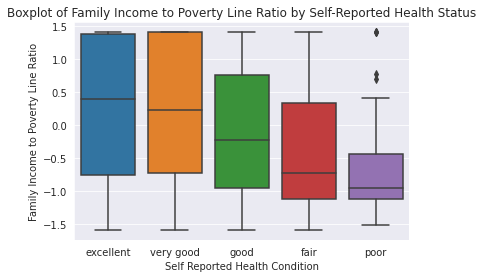

In [4]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

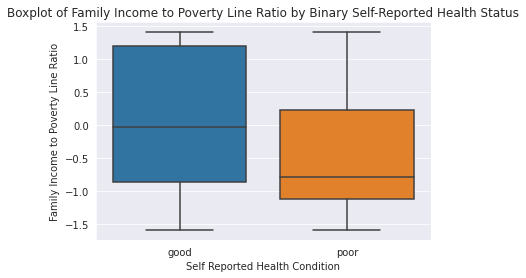

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

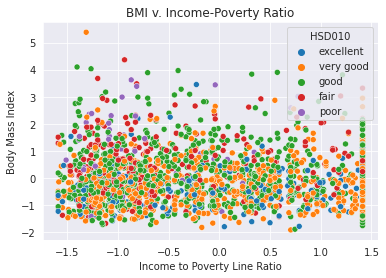

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
nhanes_scaled_PCA = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [8]:
##look at how many components are needed to explain 90% of variance
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.9)
pca.fit(nhanes_scaled_PCA)
reduced = pca.transform(nhanes_scaled_PCA)

In [9]:
pca.n_components_

120

This is a lot of components, seems unrealistic to attain explanation of 90% of the variance. We can look at a scree plot to understand how many components to maintain. 

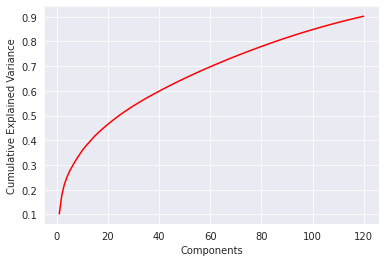

In [10]:
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),
        np.cumsum(pca.explained_variance_ratio_),
               c='red',
               label="Cumulative Explained Variance")
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Components');

In [11]:
#look at eigenvalues
pca.explained_variance_

array([23.98622994, 17.9227597 , 10.2772806 ,  6.77638662,  5.54194494,
        4.4709975 ,  4.25756533,  3.89252728,  3.66099643,  3.6024082 ,
        3.10341827,  2.8514354 ,  2.72247029,  2.71787208,  2.60977988,
        2.36191434,  2.21764838,  2.1920223 ,  2.06998109,  2.04318935,
        1.97520943,  1.94211877,  1.87192108,  1.84040967,  1.77224005,
        1.70141862,  1.67184974,  1.63182503,  1.59729655,  1.51817999,
        1.50390137,  1.4853453 ,  1.46195075,  1.45248043,  1.3937839 ,
        1.35771183,  1.33673281,  1.32374896,  1.32061755,  1.30624289,
        1.29190862,  1.27692   ,  1.24982654,  1.24139937,  1.22687198,
        1.21362547,  1.20130041,  1.18024931,  1.17226239,  1.16517021,
        1.15477314,  1.13862833,  1.13365055,  1.11689869,  1.1102154 ,
        1.09054393,  1.08742995,  1.07875592,  1.06103351,  1.05547763,
        1.05113108,  1.03148706,  1.02891757,  1.019073  ,  1.00908519,
        1.00185701,  0.99615461,  0.98870753,  0.97555555,  0.96

### Barplot of Components

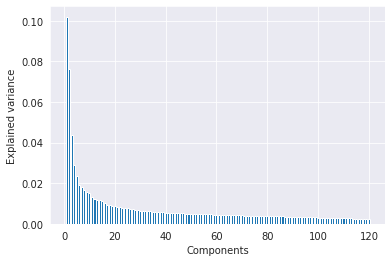

In [12]:
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.ylabel('Explained variance')
plt.xlabel('Components');

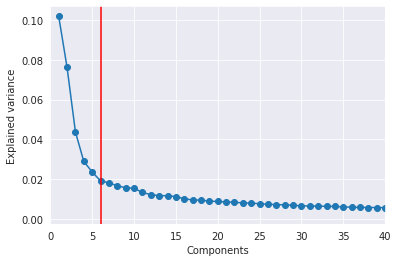

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.scatter(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.axvline(6, c='r')
plt.xlim(0,40)
plt.show();

Based on these plots, it appears that we should select 6 principal components for our analysis--that is the point where little additional information is added to the model with the inclusion of more components. Notably, even with 6 principal components only 25-30% of the variance is explained. 

In [14]:
## Train PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 6)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled_PCA)
ncomp = principalComponents_nhanes.shape[1]

In [15]:
pca_df=pd.DataFrame(data = principalComponents_nhanes,
                   columns = ['principal component %i' %n for n in range(1, ncomp + 1)])
pca_df['SEQN'] = seqn
pca_df = pca_df.set_index(['SEQN'])
pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
SEQN,,,,,,
73568,9.527811,-0.816224,-1.867108,-2.110282,-3.931063,-0.211280
73576,-5.838339,-3.692573,3.805722,-1.030308,0.392244,1.600653
73579,-0.719454,-2.573200,0.907904,-4.756000,-1.799744,0.847807
73581,3.533627,-2.576982,-3.249177,-0.406457,3.993477,1.418791
73584,-6.872094,-4.194240,0.886852,-0.848614,-0.522775,0.064007


### How many components will you use to fit a supervised learning model?

As stated above, we will use 6 principle components to fit the model (given than beyond 6, new components add little additional information to the model). But this does not effectively explaining the majority of the variance, so does not reflect a particuarly good fit for our data. 

### 2D Scatterplot of the first two components

<Figure size 432x288 with 0 Axes>

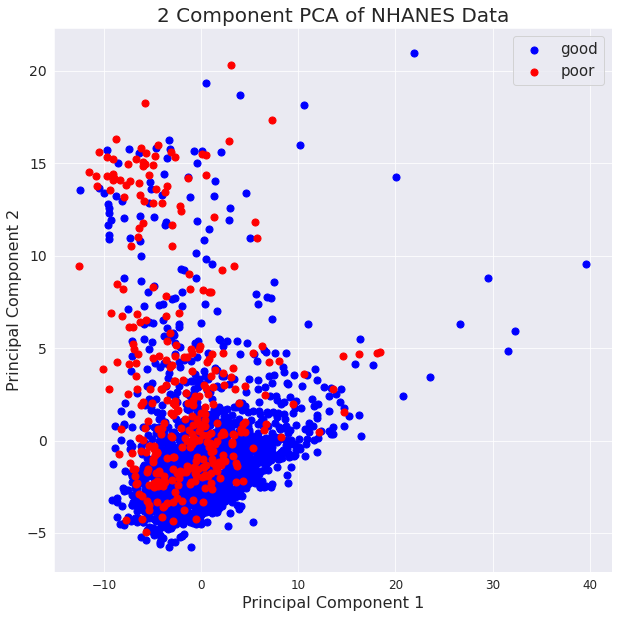

       principal component 1  principal component 2  principal component 3  \
SEQN                                                                         
73568               9.527811              -0.816224              -1.867108   
73576              -5.838339              -3.692573               3.805722   
73579              -0.719454              -2.573200               0.907904   
73581               3.533627              -2.576982              -3.249177   
73584              -6.872094              -4.194240               0.886852   

       principal component 4  principal component 5  principal component 6  
SEQN                                                                        
73568              -2.110282              -3.931063              -0.211280  
73576              -1.030308               0.392244               1.600653  
73579              -4.756000              -1.799744               0.847807  
73581              -0.406457               3.993477               1.

In [16]:
#first two component analysis scatterplot
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.title("2 Component PCA of NHANES Data",fontsize=20)
targets = ['good', 'poor']
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = nhanes_scaled['HSD010_binary'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
                , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
plt.legend(targets,prop={'size':15})
plt.show()
print(pca_df.head())

**Provide 1-2 sentences analyzing the plot:**

There is a lot of overlap between the good and poor classes in this graph, though there is more spread in principal component 1 for the good class. Given the overlap, a more complicated model may be more suitable. 

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

**Chosen clusting algorithm and justification:**

We will use K-Means clustering, which seeks to classify observations to specific cluster based on their distance to the centroid of each cluster. Centroids are iteratively determined by minimizing the sum of the squared distances between observations and centroids; this approach to clustering minimizes within cluster variance. This technique is commonly used and considered a simpler unsupervised approach to aggregating data points. 

### Cluster nhanes

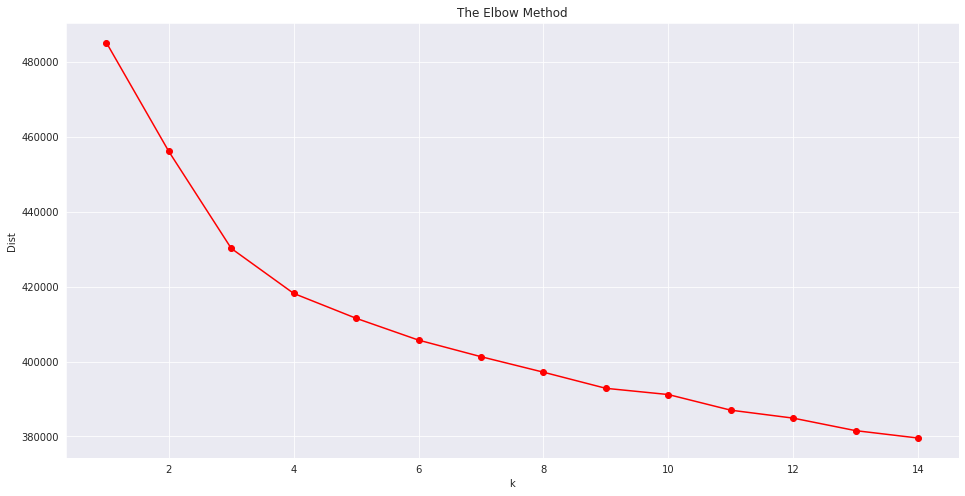

In [17]:
#set random seed
np.random.seed(10)

#find best number of clusters
dist = []
K = range(1,15)
for i in K:
    kmeanmod = KMeans(n_clusters = i, max_iter = 300)
    kmeanmod.fit(nhanes_scaled_PCA)
    dist.append(kmeanmod.inertia_)
    
#elbow method 
plt.figure(figsize=(16,8))
plt.plot(K, dist, 'ro-')
plt.xlabel('k')
plt.ylabel('Dist')
plt.title('The Elbow Method')
plt.show()



**Discuss number of clusters and justification:**

Based on this figure, we can see that the "elbow" is around 3 or 4 clusters (though it is not particularly stark). With this in mind, we will use 4 clusters for this analysis. 

In [18]:
#Elbow methods suggests that 3 or 4 clusters best fit the data. We'll use 4. 

#Kmeans with 4 clusters
kmean4 = KMeans(n_clusters = 4, max_iter = 300).fit(nhanes_scaled_PCA)

for point, label in zip(nhanes_scaled_PCA, kmean4.labels_):
    print("Coordinates:", point, "Label:", label)

Coordinates: DR1DRSTZ Label: 2
Coordinates: DR1EXMER Label: 3
Coordinates: DRABF Label: 1
Coordinates: DRDINT Label: 1
Coordinates: DR1DBIH Label: 3
Coordinates: DR1DAY Label: 2
Coordinates: DR1LANG Label: 3
Coordinates: DR1MNRSP Label: 1
Coordinates: DR1HELPD Label: 1
Coordinates: DBQ095Z Label: 1
Coordinates: DRQSPREP Label: 1
Coordinates: DR1STY Label: 3
Coordinates: DRQSDIET Label: 1
Coordinates: DR1TNUMF Label: 3
Coordinates: DR1TKCAL Label: 1
Coordinates: DR1TPROT Label: 0
Coordinates: DR1TCARB Label: 0
Coordinates: DR1TSUGR Label: 1
Coordinates: DR1TFIBE Label: 2
Coordinates: DR1TTFAT Label: 2
Coordinates: DR1TSFAT Label: 1
Coordinates: DR1TMFAT Label: 3
Coordinates: DR1TPFAT Label: 2
Coordinates: DR1TCHOL Label: 3
Coordinates: DR1TATOC Label: 1
Coordinates: DR1TRET Label: 3
Coordinates: DR1TVARA Label: 1
Coordinates: DR1TBCAR Label: 2
Coordinates: DR1TLZ Label: 2
Coordinates: DR1TVB1 Label: 1
Coordinates: DR1TVB2 Label: 0
Coordinates: DR1TNIAC Label: 1
Coordinates: DR1TVB6 Labe

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

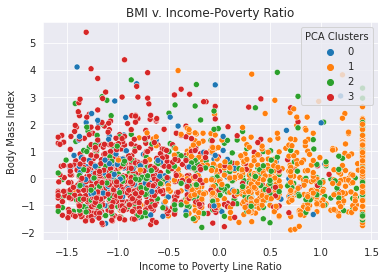

In [19]:
nhanes_scaled_PCA["PCA Clusters"]=kmean4.labels_

ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "PCA Clusters", palette = "tab10", data = nhanes_scaled_PCA)
ax.set(xlabel = "Income to Poverty Line Ratio",
       ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

**Description of this plot:** 

The majority of observations are falling in the lower range of BMI (<2.5) in this visualization of BMI vs. income to povery ratio. There is some visual separation of clusters 1 (orange) and 3 (red) by income to poverty line ratio, with cluster 3 having a higher ratio in comparison to cluster 1. Cluster 0 looks more concetrated in the lower range of income to poverty line ratio, but with some dispersed observations higher in the range. Overall, this visualizatio indicates that these clusters have some explanatory power, but not a huge amount. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [20]:
## Retrain clustering algorithm on PCA components
#PCA with 6 components from above
pca_6 = pca_df.iloc[:,0:6]
kmeanPCA = KMeans(n_clusters = 4, max_iter = 300).fit(pca_6)

# add clusters back to df
nhanes_scaled_PCA["PCA Clusters"]=kmeanPCA.labels_ 

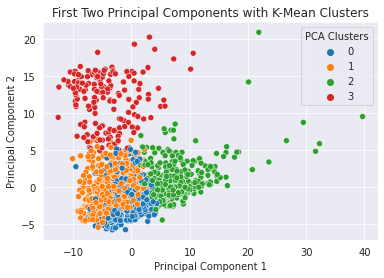

In [21]:
## Plot clusters on the 2D scatter
#2D scatter with clusters
ax = sns.scatterplot(x = pca_6['principal component 1'], 
                     y = pca_6['principal component 2'], 
                     hue = nhanes_scaled_PCA['PCA Clusters'], palette = "tab10")
ax.set(xlabel = "Principal Component 1",
       ylabel = "Principal Component 2")
ax.set_title("First Two Principal Components with K-Mean Clusters")
plt.show()

**Describe these results and compare to the 2D PCA plot from the previous step:**

In comparing this plot with the 2D PCA plot from the prior step, we can see that it is the same, but that now the PCA clusters are more discernable groups than in the previous visualization. Based on this 2D scatterplot, clusters 0 (blue) and 1 (orange) overlap quite a bit. Clusters 2 (green) and 3 (red) are more distinct and separated. Given these findings, it might make sense to group clusters 0 and 1 together into a single cluster, providing more explanatory power for the data with a single component rather than two separate but overlapping components. 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [22]:
#set up variables
y = nhanes_scaled['HSD010_binary'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1) # drop out any columns that aren't features
y = y.replace(['good', 'poor'], [0, 1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [23]:
#import packages and functions
import keras
from keras.utils import np_utils 

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)
print(X_test.shape[1], y_test.shape[1])

241 2


In [24]:
model = Sequential()

model.add(
    Dense(X_test.shape[1], input_dim = X_test.shape[1], kernel_initializer = 'normal', activation = 'relu')
)

model.add(
    Dense(y_test.shape[1], kernel_initializer = 'normal', activation = 'sigmoid')
)

## Add any additional layers you wish here

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200, verbose = 2)

Epoch 1/10
8/8 - 1s - loss: 0.5710 - accuracy: 0.7171 - val_loss: 0.4079 - val_accuracy: 0.8430 - 716ms/epoch - 90ms/step
Epoch 2/10
8/8 - 0s - loss: 0.3523 - accuracy: 0.8676 - val_loss: 0.3680 - val_accuracy: 0.8566 - 41ms/epoch - 5ms/step
Epoch 3/10
8/8 - 0s - loss: 0.3162 - accuracy: 0.8786 - val_loss: 0.3608 - val_accuracy: 0.8624 - 34ms/epoch - 4ms/step
Epoch 4/10
8/8 - 0s - loss: 0.2848 - accuracy: 0.8895 - val_loss: 0.3550 - val_accuracy: 0.8624 - 37ms/epoch - 5ms/step
Epoch 5/10
8/8 - 0s - loss: 0.2562 - accuracy: 0.9025 - val_loss: 0.3468 - val_accuracy: 0.8663 - 39ms/epoch - 5ms/step
Epoch 6/10
8/8 - 0s - loss: 0.2330 - accuracy: 0.9141 - val_loss: 0.3453 - val_accuracy: 0.8643 - 51ms/epoch - 6ms/step
Epoch 7/10
8/8 - 0s - loss: 0.2114 - accuracy: 0.9218 - val_loss: 0.3441 - val_accuracy: 0.8663 - 35ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 0.1929 - accuracy: 0.9309 - val_loss: 0.3450 - val_accuracy: 0.8663 - 37ms/epoch - 5ms/step
Epoch 9/10
8/8 - 0s - loss: 0.1744 - a

We're seeing pretty high accuracy scores across these models. This makes sense, given that this model is accounting for all of the features in the model, compared to PCA which seeks to reduce features and in this modelling instance only explained a minority of the variance in our model. 

### Neural Network on Principal Components

In [25]:
y = nhanes_scaled['HSD010_binary']
y = y.replace(["good", "poor"], [0,1])
X_PCA = pca_6
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size = 0.25, random_state = 10)

y_train =  np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)
print(X_test.shape[1], y_test.shape[1])

model = Sequential()

model.add(
    Dense(X_test.shape[1], input_dim = X_test.shape[1], kernel_initializer = 'normal', activation = 'relu')
)

model.add(
    Dense(y_test.shape[1], kernel_initializer = 'normal', activation = 'sigmoid')
)

model.compile (loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200, verbose = 2)

6 2
Epoch 1/10
8/8 - 0s - loss: 0.6792 - accuracy: 0.8359 - val_loss: 0.6745 - val_accuracy: 0.8488 - 495ms/epoch - 62ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6715 - accuracy: 0.8359 - val_loss: 0.6663 - val_accuracy: 0.8488 - 24ms/epoch - 3ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6630 - accuracy: 0.8359 - val_loss: 0.6571 - val_accuracy: 0.8488 - 322ms/epoch - 40ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6532 - accuracy: 0.8359 - val_loss: 0.6469 - val_accuracy: 0.8488 - 42ms/epoch - 5ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6424 - accuracy: 0.8359 - val_loss: 0.6355 - val_accuracy: 0.8488 - 28ms/epoch - 4ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6304 - accuracy: 0.8359 - val_loss: 0.6229 - val_accuracy: 0.8488 - 28ms/epoch - 3ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6172 - accuracy: 0.8359 - val_loss: 0.6094 - val_accuracy: 0.8488 - 28ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6030 - accuracy: 0.8359 - val_loss: 0.5949 - val_accuracy: 0.8488 - 28ms/epoch - 4ms/step
Epoch 9/10
8/8 - 0s - loss: 0.58

Looking at the validation accuracy scores, running a neural network with PCA allows for less overfitting with our data than a neural network with all features. Our accuracy scores are slightly lower for NN with PCA compared to with all features, but the fall off from the train set to test set accuracy is smaller, reflecting that this PCA provides a more generalizable representation of the overall data (not just the data in the training set). 

### Neural Network on Principal Components + Cluster 

In [26]:
#set up
y = nhanes_scaled['HSD010_binary']
y = y.replace(["good", "poor"], [0,1])
X = pca_6
clusters = nhanes_scaled_PCA["PCA Clusters"]
X = X.join(clusters) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [27]:
y_train =  np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)

print(X_test.shape[1], y_test.shape[1])

7 2


In [28]:
#define and fit model

model = Sequential()

model.add(
    Dense(X_test.shape[1], input_dim = X_test.shape[1], kernel_initializer = 'normal', activation = 'relu')
)

model.add(
    Dense(y_test.shape[1], kernel_initializer = 'normal', activation = 'sigmoid')
)


model.compile (loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200, verbose = 2)

Epoch 1/10
8/8 - 0s - loss: 0.6977 - accuracy: 0.3508 - val_loss: 0.6946 - val_accuracy: 0.4903 - 466ms/epoch - 58ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6916 - accuracy: 0.5853 - val_loss: 0.6885 - val_accuracy: 0.7132 - 25ms/epoch - 3ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6862 - accuracy: 0.7636 - val_loss: 0.6830 - val_accuracy: 0.8450 - 22ms/epoch - 3ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6812 - accuracy: 0.8301 - val_loss: 0.6777 - val_accuracy: 0.8469 - 26ms/epoch - 3ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6763 - accuracy: 0.8359 - val_loss: 0.6723 - val_accuracy: 0.8488 - 25ms/epoch - 3ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6711 - accuracy: 0.8359 - val_loss: 0.6667 - val_accuracy: 0.8488 - 25ms/epoch - 3ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6656 - accuracy: 0.8359 - val_loss: 0.6605 - val_accuracy: 0.8488 - 23ms/epoch - 3ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6595 - accuracy: 0.8359 - val_loss: 0.6537 - val_accuracy: 0.8488 - 22ms/epoch - 3ms/step
Epoch 9/10
8/8 - 0s - loss: 0.6526 - a

**Compare and contrast how well each algorithm did.**

When we added cluster membership to our neural network model, accuracy did not change for this model compared to the model without cluster membership. Overall, this is not an improvement over the last model. 

**Which featurization technique would you pick and why?**

Accuracy measures how well the model predicts. The validation accuracy is highest for the neural network trained on the original features.

Loss represents the summation of errors in the model. If the errors are high, the loss will be high. Looking at how loss changes over time allows us to gauge whether our model is learning. If the loss is not decreasing, the model might not be learning. If it’s decreasing in the training set but not in the test/validation set, then the model might be overfitting. **This appears to be the case for the neural network trained on the original features. However, for the other two models, while the loss decreases in both the training and validation but is much higher.**

Low accuracy but high loss means that the model creates big errors in most of the data. If both loss and accuracy are low, it means the model makes small errors in most of the data. If they’re both high, it makes big errors in some of the data. If accuracy is high and the loss is low, then the model makes small errors on just some of the data, which would be the ideal case. **Despite some concern of overfitting, the neural network trained on the original features seems best as it has the highest validation accuracy and the lowest validation loss.**

## Discussion Questions

**1. In your own words, what is the difference between PCA and clustering?**



Both principal components analysis (PCA) and clustering imrpove the interpretability of data, but in different ways. Clustering means sorting the data into n buckets, each with similar characteristics. In other words, the data is presented according to a sort of typology, which can make a large data set easier to understand. 

PCA, in contrast, reduces the dimensionality of the data by collapsing redundant or irrelevant features into one another. A data set with, say, 100 features could therefore be reduced to a significantly smaller number of "principal components" that explain most of the variation.  

**2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?**

Combining PCA and clustering has the advantage of reducing the dimensionality of the data. When working with large datasets, combining these two methods could results in a better representation of the data, as PCA can provide a clearer representation of data "signal" while reducing "noise" compared to the original data. Reduced dimensionality PCA data can accordingly show more distinction between clusters than original data, making results more interpretable. Comparing the 2D PCA scatterplot without clustering and the PCA scatterplot with clustering allowed us to see that clustering created clearer boundaries between groups than just PCA alone. 

However, in training the neural net found that the validation loss and validation accuracy were very similar for PCA and PCA with clustering. Cluster analysis groups observations while PCA groups variables. In this case it appears that grouping observations doesn't provide much value above and beyond grouping variables, which likely means that these groupings are very closely related.

**3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"**

As mentioned above in response to question #1, unsupervised techniques like PCA and clustering are useful in part because they make data more interpretable by, for example, organizing it into clusters or reducing the number of features. As such, unsupervised techniques can be an important part of pre-processing when dealing with "big data" with a lot of features. Excessive, redundant, or irrelevant features can be removed, which will have the dual benefit of reducing the computational load as well as creating a "cleaner" data set that can be fitted to supervised, predictive models more easily. Furthermore, if cluster analysis reveals that the dataset is divided into clearly delineated groups, it may make sense depending on the application to extract particular clusters for further analysis.  